**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/msgtsuzuki/saved_models/blob/main/tutorial15/Tutorial15-N.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/msgtsuzuki/saved_models/blob/main/tutorial15/Tutorial15-N.ipynb)


# Tutorial 15: CRL - Causal Identifiability from Temporal Intervened Sequences
Understanding the latent causal factors of a dynamical system from visual observations is a crucial step towards agents reasoning in complex environments. In this tutorial, we will have a closer look at CITRIS ([Lippe et al., 2022a](https://arxiv.org/abs/2202.03169)), a variational autoencoder framework that learns causal representations from temporal sequences of images in which underlying causal factors have possibly been intervened upon. As shown in the figure below, CITRIS utilizes both temporal consistency and interventions (orange) in order to identify causal variables (blue) from an image sequence. In contrast to previous work in causal representation learning, CITRIS considers causal variables as potentially multidimensional vectors. Furthermore, by introducing a normalizing flow, CITRIS can be easily extended to leverage and disentangle representations obtained by already pretrained autoencoders.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/CITRIS-setup.png" width="70%"></center>

In the remainder of this tutorial, we first provide a brief introduction to the recently emerging field of causal representation learning (CRL). Then, we will look into the inner workings of CITRIS in greater detail, before performing a number of experiments to demonstrate its capabilities.

Let’s start with importing our standard libraries here (If you are running in Windows, modify the 'CHECKPOINT_PATH' to saved_models\tutorial15).

In [97]:
## Standard libraries
import os
import sys
import importlib
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()
import ipywidgets as widgets

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

try:
    from scipy.stats import norm
except ModuleNotFoundError: # The DL2022 environment does not have Scipy installed by default. Hence, we do it here if necessary.
    !pip install --quiet scipy
    from scipy.stats import norm

try:
    import networkx as nx
except ModuleNotFoundError: # The DL2022 environment does not have NetworkX installed by default. Hence, we do it here if necessary.
    !pip install --quiet networkx
    import networkx as nx


DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models/tutorial15"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# Import a minimized version of the code implementation of CITRIS
if not os.path.exists('CITRIS_DL2'):
    !git clone https://github.com/msgtsuzuki/CITRIS_DL2

sys.path.append('CITRIS_DL2')
module_name = 'CITRIS_DL2.models.citris_nf'
importlib.invalidate_caches()
CITRISNF = importlib.import_module(module_name).CITRISNF
CITRISNF.device = device

Seed set to 42


Device: cpu


<Figure size 1000x500 with 0 Axes>

We also have a few pre-trained models, which we download below.

In [98]:
import urllib.request
from urllib.error import HTTPError

base_url = "https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/"
pretrained_files = ['ae.ckpt', 'citris.ckpt']
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try later again, or contact the author with the full output including the following error:\n", e)

## Causal Representation Learning

Over the last decades, machine learning has become one of the most prominent approaches in artificial intelligence. One major advantage of machine learning approaches over earlier AI paradigms is their ability to automatically learn useful features from high-dimensional observations. However, in doing so, machine learning methods generally only leverage statistical information in data, and not the causal process that underlies how that data was generated in the first place. Consequently, they often struggle to perform tasks that involve out-of-domain generalization and planning.

Causal inference, on the other hand, goes beyond the statistical description of data, and instead aims to reason about the effect of *interventions* in the system underlying the data. In order to perform such causal reasoning, it is required that the causal variables and their relations are provided beforehand. However, many real-world observations, such as objects in images, are not structured into such variables to begin with.

Thus, an emerging field of research is *causal representation learning* (CRL), in which the task is to identify such causal variables including their relations from low-level data such as images or videos ([Schölkopf et al., 2021](https://arxiv.org/abs/2102.11107)). The central idea here is that a low-level observation $X$ is merely a view on the state of a causal system $C_1, \ldots, C_n$:

$$
X = h(C_1, \ldots, C_n),
$$

where $h: \mathcal{C} \rightarrow \mathcal{X}$ is some non-linear function that maps from the causal system's state space to the observational space. In CRL, we are then interested in approximating the inverse of $G$ (e.g. with a neural network) in order to map a low-level observation to high-level causal variables that are useful  for a set of downstream tasks of interest, as shown in the figure below.
<div>

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/crl-idea.png" width="70%"></center>

## Causal Setting: TempoRal Intervened Sequences (TRIS)

The setting in which CITRIS aims to identify causal variables is TempoRal Intervented Sequences (TRIS). In TRIS, we assume that the underlying latent causal process is a dynamic Bayesian network (DBN) over a set of $K$ causal factors $(C_1, C_2, \ldots, C_K)$. In the corresponding causal graph $G = (V, E)$, each node $i \in V$ is associated with the causal factor $C_i$, which can be scalar or vector-valued, and each edge $(i, j) \in E$ represents a causal relation from $C_i$ to $C_j$: $C_i \to C_j$.

TRIS further assumes that each causal factor $C_i$ is instantiated at each time step $t$, denoted $C_i^t$, and its causal parents can only be causal factors at time $t - 1$. In other words, we assume that DBN resembles a temporal latent causal process with $K$ causal factors $(C_1^t, C_2^t, \ldots, C_K^t)_{t=1}^T$ that change over time according to the temporal dynamics governed by the DBM. Crucially, in TRIS, some causal factors might have been intervened upon at each time step, and we have access to the corresponding intervention targets (but not the intervention values). We denote these intervention targets by the binary vector $I^t \in \{0, 1\}^K$, whose $i$-th component is 1 if and only if the causal factor $C_i$ has been intervened upon at time $t$ (i.e., $C_i^t$ has been intervened upon).

It is important to note that we never observe the causal factors $(C^t)_{t=1}^T$ in TRIS, and instead only have access to a temporal sequence of high-level observations $(X^t)_{t=1}^T$ along with the corresponding intervention targets $(I^t)_{t=2}^T$. Each high-level observation represents a noisy and entangled view of all causal factors. Formally, $X^t = h(C_1^t, C_2^t, \ldots, C_K^t, E_o^t)$, where $E_o^t$ represents noise, and $h: \mathcal{C} \times \mathcal{E} \rightarrow \mathcal{X}$ is a function from the causal factor space $\mathcal{C}$ and the space of the noise variables $\mathcal{E}$ to the observation space $\mathcal{X}$. The overall set-up of TRIS is illustrated below, with observed variables shown in gray and latent variables in white.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/TRIS.png" width="60%"></center>

It is noteworthy that the set-up of TRIS is general enough to be able to describe many dynamical systems. In fact, CITRIS (and iCITRIS ([Lippe et al., 2022b](https://arxiv.org/abs/2206.06169)), which we do not discuss in this notebook) have been successful in identifying the causal structure in settings that range from 3D rendered objects to pinball and pong.

|     |     |     |     |     |
| --- | --- | --- | --- | --- |
| <img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/ball_in_boxes.gif" width="200px"> | <img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/causal-3dIdent.gif" width="200px"> | <img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/interventional_pong2.gif" width="200px"> | <img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/voronoi.gif" width="200px"> | <img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/pinball2.gif" width="200px"> |

In the remainder of this tutorial, we will focus on the Causal3DIdent dataset, which we will describe in further detail next.

### Causal3DIdent

Now we will look into the Causal3DIdent dataset. It contains a sequence of images with the intervention targets at each time-step. In the below cell, we will load a small sample of the dataset.

In [99]:
causal3d_dataset = dict(np.load(os.path.join('CITRIS_DL2', 'data', 'causal3d.npz')))
print(causal3d_dataset.keys())

dict_keys(['images', 'interventions'])


The intervention targets declare which causal variables were intervened upon. In Causal3DIdent, we consider the following 7 causal variables (with 11 causal dimensions in total):

| Variable                  | Values                                            |
| ------------------------- | ------------------------------------------------- |
| Object position (pos_o)   | $$[x, y, z] \in [-2, 2]^3$$                         |
| Object rotation (rot_o)   | $$[\alpha,\beta] \in [0,2\pi)^2$$                   |
| Spotlight rotation (rot_s)| $$\theta \in [0,2\pi)$$                             |
| Object hue (hue_o)        | $$h_\text{obj} \in [0,2\pi)$$                       |
| Spotlight hue  (hue_s)    | $$h_\text{light} \in [0,2\pi)$$                     |
| Background hue (hue_b)    | $$h_\text{bg} \in [0,2\pi)$$                        |
| Object shape  (obj_s)     | $$s \in \{\text{teapot, cow, head, horse, armadillo, dragon, hare}\}$$  |

Note that in our experiments, we will use a variant of Causal3DIdent that only contains the teapot as a possbile object shape. The relations among these causal variables are shown in the figure below.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/Causa3DIdentGraph.png" width="50%"></center>

Below you can see what causal variables were intervened at each time-step. The $i$-th intervention targets imply that the causal variables of the $(i-1)$-th image were intervened, resulting in the $i$-th image.

In [100]:
time_steps = 4
print(causal3d_dataset['interventions'][0:time_steps])

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]]


Note that each interention target has 12 dimensions instead of 11. This is because the last dimension is the object material, which is not modeled by CITRIS.

In the next cell, we will plot a sequence of images. Note how the intervention targets, printed above, affect the object and the surrounding environment.

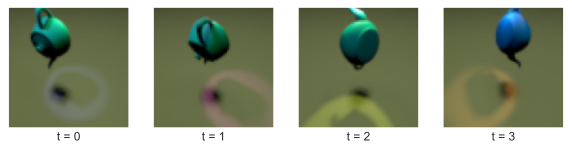

In [101]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(time_steps):
    plt.subplot(1, time_steps, i+1)
    plt.imshow(causal3d_dataset['images'][i])
    plt.xlabel(f't = {i}')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Theoretical Framework of CITRIS

### Minimal Causal Variables

In TRIS, we generally cannot disentangle two causal factors if they are always intervened upon jointly, or, on the contrary, if they are never intervened upon. Furthermore, multidimensional causal variables are not always identifiable in TRIS as interventions might only affect a subset of its dimensions. Instead, we may only be able to identify *minimal causal variables*, which only model the information of a causal factor that is strictly affected by a provided intervention. For example, consider the causal process illustrated below, where a ball can move freely within the box it is currently in, but can only jump into another box under an intervention (which keeps the relative position of the ball within the box intact).


<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/ball_in_boxes.jpg" width="30%"></center>

If we were to model this process by two causal variables, the relative position within the box $x'$ (on which we never intervene) and the current box $b$, we are only able to identify the causal variable $b$, since $x'$ is not affected by the interventions. In other words, $b$ is the minimal causal variable in this example.


To formalize the notion of minimal causal variables, consider an invertible map $s_i: \mathcal{D}_i^{M_i} \rightarrow \mathcal{D}_i^\text{var} \times \mathcal{D}_i^\text{inv}$ that splits each causal variable $C_i^t$ into an *intervention-dependent* part $s^\text{var}_i(C^{t}_i)$ and an *intervention-independent* part $s^\text{inv}_i(C^{t}_i)$ (note that this invertible map is not unique).  We are interested in identifying the split where $s^\text{var}_i(C^{t}_i)$ *only* contains information that truly depends on the intervention. Under this split, $s^\text{var}_i(C^{t}_i)$ is defined as the *minimal causal variable* and denoted by $s^{\text{var}^*}_i(C^{t}_i)$.

### Learning the Minimal Causal Variables

In order to learn the minimal causal variables in TRIS, CITRIS approximates the inverse of the observation function based on data triplets $\{x^t, x^{t+1}, I^{t+1}\}$ by learning two components.
1. An invertible mapping from observations to latent space: $g_\theta: \mathcal{X} \to \mathcal{Z}$.
2. An assignment function $\psi: [\![1..M]\!]\to[\![0..K]\!]$ that maps each dimension of $\mathcal{Z}$ to a causal factor in $\mathcal{C}$.

For the assignment function, $\psi(j)=0,j\in[\![1..M]\!]$ indicates that the latent dimension $z_j$ does not correspond to any dimension of the minimal causal variable, but rather to some dimension of $s^\text{inv}_i(C^{t}_i)$, and $z_{\psi_{i}}=\{z_j \mid j\in[\![1..M]\!], \psi(j)=i\}$ denotes the set of latent variables that $\psi$ assigns to the causal variable $C_i$.

To encourage a disentanglement of the causal factors, CITRIS model a **transition prior** in the latent space that conditions each latent variable on exactly one of the intervention targets:

$$
p_{\phi}\left(z^{t+1}|z^{t}, I^{t+1}\right) = \prod_{i=0}^{K}p_{\phi}\left(z_{\psi_i}^{t+1}|z^{t}, I_{i}^{t+1}\right),
$$

where $I_0^{t+1}=0$. Combining the transition prior and the invertible mapping $g_\theta$, the objective of CITRIS is to maximize the following likelihood:

$$
p_{\phi,\theta}(x^{t+1}|x^{t},I^{t+1})=\left|\frac{\partial g_{\theta}(x^{t+1})}{\partial x^{t+1}}\right|p_{\phi}(z^{t+1}|z^{t}, I^{t+1})
$$

If a model $\mathcal{M}$ maximizes the information content of $z_{\psi_0}$ under the constraint of maximizing this likelihood $\mathcal{L}_{\phi,\theta}(x^{t+1}|x^{t},I^{t+1})$ and no intervention variable is a deterministic function of any other intervention variable, then $\mathcal{M}$ is shown to identify any causal system $\mathcal{S}$ (i.e., it identifies the minimal causal variables of $\mathcal{S}$ up to an invertible transformation). Intuitively, this means that the latent variables $z_{\psi_i}$ only model the information of $C_i$ that strictly depends on the intervention targets $I_i^{t+1}$.

## Practical Implementation of CITRIS

Thus far, we have sketched a theoretical framework to identify causal variables from an image sequence with known intervention targets. We are now ready to provide a practical implementation of the model $\mathcal{M}$. The original paper proposes two variants for such a model: CITRIS-VAE and CITRIS-NF.

### CITRIS-VAE

Recall that CITRIS approximates $h^{-1}: \mathcal{X} \to \mathcal{C} \times \mathcal{E}$ by learning two components: the intertible mapping $g_\theta: \mathcal{X} \to \mathcal{Z}$, and the assignment function $\psi: [\![1..M]\!]\to[\![0..K]\!]$. CITRIS-VAE approximate $g_\theta$ via a variational autoencoder (AE), with encoder $q_\theta$ and decoder $p_\theta$, that optimizes the following Evidence Lower Bound (ELBO):

$$
\mathcal{L}_{\text{ELBO}} = -\mathbb{E}_{z^{t+1}}\left[\log \underbrace{p_{\theta}\left(x^{t+1}|z^{t+1}\right)}_\text{Decoder}\right] + \mathbb{E}_{z^{t},\psi}\left[\sum_{i=0}^{K} D_{\mathrm{KL}}\left(\underbrace{q_{\theta}(z_{\psi_{i}}^{t+1}|x^{t+1})}_\text{Encoder}|| \underbrace{p_{\phi}(z_{\psi_{i}}^{t+1}|z^{t}, I_{i}^{t+1})}_\text{Transition Prior}\right)\right]
$$

To ensure that blocks of latent variables that are assigned to different causal variables are independent conditioned on the latent variables of the previous time steps and the interventions (i.e., the $z_{\psi_i}^{t+1}$'s are independent conditioned on $z^t$ and $I_i^{t+1}$), the KL divergence term utilizes the prior definition of the transition prior. Thereby, the assignment function $\psi$ is learned via a Gumbel-Softmax distribution per latent variable. The overall setup of CITRIS-VAE is visualized below.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/CITRIS-VAE.png" width="50%"></center>

Now that we have discussed CITRIS-VAE in detail, we can implement a simplified version of it:

In [102]:
class CITRISVAE_MINIMAL(nn.Module):
    """
    This is a minimal implementation of CITRIS-VAE and is meant for educational purposes.
    Several steps and details have been omitted for clarity.
    You can find the full version at:
    https://github.com/msgtsuzuki/CITRIS_DL2/blob/main/models/citris_vae/lightning_module.py
    """

    def __init__(self, encoder, decoder, transition_prior):
        super().__init__()

        # Encoder-Decoder
        self.encoder, self.decoder = encoder, decoder

        # Transition prior
        self.prior_t1 = transition_prior

    def forward(self, x):
        """ Returns the reconstruction of x"""
        # Encode
        z_mean, z_logstd = self.encoder(x)

        # Reparameterization trick
        z_sample = z_mean + torch.randn_like(z_mean) * z_logstd.exp()

        # Decode
        x_rec = self.decoder(z_sample)

        return x_rec, z_sample, z_mean, z_logstd

    def _get_loss(self, batch):
        """ Returns the loss for a batch of data"""
        # Unpack batch
        imgs, labels, target = batch

        # Encode
        z_mean, z_logstd = self.encoder(imgs)

        # Reparameterization trick
        z_sample = z_mean + torch.randn_like(z_mean) * z_logstd.exp()

        # Decode
        x_rec = self.decoder(z_sample)

        # Calculate KL divergence between every pair of frames
        kld = self.prior_t1.kl_divergence(z_t=z_mean[:, :-1],
                                          target=target,
                                          z_t1_mean=z_mean[:, 1:],
                                          z_t1_logstd=z_logstd[:, 1:],
                                          z_t1_sample=z_sample[:, 1:])

        # Reconstruction loss
        rec_loss = F.mse_loss(x_rec, labels[:, 1:], reduction='none').sum()

        # Get the full loss
        loss = (kld + rec_loss.sum(dim=1)).mean()

        return loss

### CITRIS-NF

One disadvantage of using a VAE is that it may struggle to model complex images that contain many details that are small yet relevant to model the causal system. CITRIS-NF overcomes this issue by separating the learning process of $g_\theta$ into the following two components:
1. **(Pretrained) Autoencoder (AE)**: Learns to encode the high-dimensional observations *without* disentangling the dimensions in the latent space.
2. **Normalizing Flow (NF)**: Learns to map the entangled latent representation of the autoencoder into a disentangled one.

In contrast to the VAE setup, the autoencoder does not require the latent distribution to be similar to a transition prior, thus allowing it to model more complex marginal distributions. We visualize the setup of CITRIS-NF below.


<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/CITRIS-NF.png" width="50%"></center>


While it is not strictly necessary the understand normalizing flows to follow the remainder of this tutorial, we highly recommend having a look at [Tutorial 11](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html#) or the [following video](https://www.youtube.com/watch?v=i7LjDvsLWCg) for readers that are interested in learning more about them.

Similar to the VAE setup, we implement a simplified version of CITRIS-NF below:

In [103]:
class CITRISNF_MINIMAL(nn.Module):
    """
    This is a minimal implementation of CITRIS-NF and is meant for educational purposes.
    Several steps and details have been omitted for clarity.
    You can find the full version at:
    https://github.com/msgtsuzuki/CITRIS_DL2/blob/main/models/citris_nf/lightning_module.py
    """

    def __init__(self, encoder, decoder, transition_prior, flow):
        super().__init__()

        # Encoder-Decoder
        self.encoder, self.decoder = encoder, decoder

        # Transition prior
        self.prior_t1 = transition_prior

        # Normalizing Flow
        self.flow = flow

    def forward(self, x, noise_level=0.0):
        """ Returns the reconstruction of x
            Note that we do not use the flow in the forward pass.
            The flow is used only to disentangle the latent space.
        """
        # Encode
        z = self.encoder(x)

        # Add some noise
        z = z + torch.randn_like(z) * noise_level

        # The decoder expects the original latent space.
        # Executing the flow and then reversing has no effect.
        # Thus, we skip the flow here.
        # # Execute the flow to disentangle the latent space
        # z, _ = self.flow(z)
        # # Reverse the flow to get the original latent space
        # z = self.flow.reverse(z)

        # Decode
        x_rec = self.decoder(z)

        return x_rec, z

    def _get_loss(self, batch, noise_level=0.0):
        """ Returns the loss for a batch of data"""

        # Unpack batch
        imgs, target = batch

        # Encode
        z = self.encoder(imgs)

        # Add some noise
        z = z + torch.randn_like(z) * noise_level

        # Execute the flow
        z_sample, ldj = self.flow(z)  # ldj = log(det(Jacobian))

        # Calculate the negative log likelihood of the transition prior
        nll = self.prior_t1.sample_based_nll(z_t=z_sample[:, :-1],
                                             z_t1=z_sample[:, 1:],
                                             target=target)

        # Add LDJ and prior NLL for full loss
        loss = nll + ldj

        return loss

### Target Classifier (optional)

To further guide the disentanglement in latent space, both CITRIS-VAE and CITRIS-NF can make use of a target classifier that is trained to predict the intervention targets from the latent variables over time, *i.e.*, $p(I^{t+1}|z^{t},z_{\psi_{i}}^{t+1})$ for $i\in[\![0..K]\!]$. To achieve this, we can train $z_{\psi_{i}}^{t+1}$ to have higher mutual information with the intervention target $I_i^{t+1}$ of its intended causal variable $C_i$.

## Experiments

Now that we have discussed how CITRIS works, we are ready to perform some experiments to gain a better understanding of its capabilities. First, we will study CITRIS' capabilities to disentangle the causal factors on the Causal3DIdent dataset. Then, we will demonstrate how we can use the learned latent dimensions of CITRIS to perform interventions in the image space, and conversely analyze how these latent dimensions are affected if we change a single causal variable in the input image.

For our experiments, we will use variant of CITRIS-NF that has been pre-trained on the Causal3DIdent dataset discussed previously.

In [104]:
pretrained_CITRIS_path = os.path.join(CHECKPOINT_PATH, "citris" + ".ckpt")

if os.path.isfile(pretrained_CITRIS_path):
    print(f"Found pretrained model at {pretrained_CITRIS_path}, loading...")
    model = CITRISNF.load_from_checkpoint(pretrained_CITRIS_path)
    model.eval()

Found pretrained model at saved_models/tutorial15\citris.ckpt, loading...


### Triplet Evaluation

To reveal complex dependencies between latent variables, we first perform a parameter-free evaluation involving triplets of images. The first two elements of the triplets are randomly sampled from the original test dataset, and the third element is created based on a random combination of causal factors of the first two images.

Let's first inspect what a single image triplet might look like:

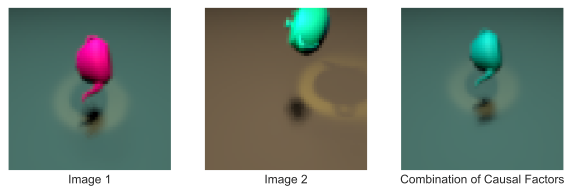

In [105]:
triplets = dict(np.load(os.path.join('CITRIS_DL2', 'data', 'causal3d_triplets.npz')))

image_triplet = triplets['images'][0]

plt.rcParams['figure.figsize'] = [10, 5]
labels = ['Image 1', 'Image 2', 'Combination of Causal Factors']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(image_triplet[i])
    plt.xlabel(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

The triplet dataset further stores a binary mask $\mathbf{m} \in \mathbb{R}^K$, whose $k$-th element is $1$ if $C_k$ was taken from image 2, and $0$ if it was taken from image 1.

In [106]:
triplet_mask = triplets['mask'][0]
mask_names = ['x_position', 'y_position', 'z_position', 'alpha_rotation', 'beta_rotation', 'gamma_rotation', 'theta_spot_light', 'hue_object', 'hue_spot_light', 'hue_background', 'shape', 'material']

assigned_to = {0: [], 1: []}
for mask_name, mask in zip(mask_names, triplet_mask):
    assigned_to[mask].append(mask_name)

print(f"Assigned to image 1: {assigned_to[0]}")
print(f"Assigned to image 2: {assigned_to[1]}")

Assigned to image 1: ['y_position', 'z_position', 'alpha_rotation', 'beta_rotation', 'theta_spot_light', 'hue_spot_light', 'hue_background']
Assigned to image 2: ['x_position', 'gamma_rotation', 'hue_object', 'shape', 'material']


For evaluation, we encode the two test images independently, perform the combination of ground-truth causal factors as is done for the third image in latent space, and use the decoder to generate a new image, which ideally resembles the ground-truth third image.

In [107]:
@torch.no_grad()
def encode(imgs):
    imgs = torch.from_numpy(imgs)[...,:3]
    if len(imgs.shape) == 5:
        imgs = imgs.permute(0, 1, 4, 2, 3)
        imgs = imgs.flatten(0, 1)
    else:
        imgs = imgs.permute(0, 3, 1, 2)
        imgs = imgs.flatten(0)
    print(imgs.shape)
    imgs = imgs.float() / 255.0
    imgs = imgs * 2.0 - 1.0
    encs = model.autoencoder.encoder(imgs)
    encs = encs.unflatten(0, (-1, triplets['images'].shape[1]))
    return encs

In [108]:
@torch.no_grad()
def triplet_reconstruction(imgs, source):
    # Encode Images
    x_encs = encode(imgs)

    # Pass through the normalizing flow to disentagle the latent space
    input_samples, _ = model.flow(x_encs[:,:2].flatten(0, 1))
    input_samples = input_samples.unflatten(0, (-1, 2))

    # Get the assignment of the latent variables to the causal ones
    target_assignment = model.prior_t1.get_target_assignment(hard=True)

    # Take the latent variables from the encoding of image 1 respective to the mask
    mask_1 = (target_assignment[None,:,:] * (1 - source[:,None,:])).sum(dim=-1)
    # Take the rest from image 2
    mask_2 = 1 - mask_1

    # Create an encoding with the combination of causal variables from image 1 and image 2
    triplet_samples = mask_1 * input_samples[:,0] + mask_2 * input_samples[:,1]

    # Reverse the flow from the triplet_samples
    triplet_samples = model.flow.reverse(triplet_samples)

    # Decode and get the new image
    triplet_rec = model.autoencoder.decoder(triplet_samples)

    return triplet_rec

In [110]:
triplet_rec = triplet_reconstruction(triplets['images'][0:3], triplets['mask'][0:3, [0,1,2,3,4,6,7,8,9,10]])

torch.Size([9, 3, 64, 64])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Finally, we plot reconstructed triplet images next to the original image triplets.

In [ ]:
def normalize(imgs):
    imgs = imgs.numpy().transpose(1,2,0)
    imgs = (imgs + 1)/2
    imgs = imgs*255
    return imgs.astype(int)


fig, axs = plt.subplots(3, 4, figsize=(8, 6))

for i in range(3):
    axs[i, 0].imshow(triplets['images'][i][0])
    axs[i, 0].set_xlabel('Image 1')

    axs[i, 1].imshow(triplets['images'][i][1])
    axs[i, 1].set_xlabel('Image 2')

    axs[i, 2].imshow(triplets['images'][i][2])
    axs[i, 2].set_xlabel('Ground Truth')

    axs[i, 3].imshow(normalize(triplet_rec[i]))
    axs[i, 3].set_xlabel('Predicted')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

The resulting triplet image that is reconstructed by CITRIS based solely on the combined latent dimensions closely resembles the true combined image. This shows that the latent dimensions learned by CITRIS do not only capture the distribution of the image space, but are also disentangled in the sense each latent dimension only models a single causal variable, and contains no information about any of the other causal variables.

### Performing interventions

The results above indicate that CITRIS can learn causal representations from temporal sequences, and suggest that we can use its latent dimensions to control what values each causal variable takes in the generated images. In other words, we can use its latent dimensions to perform interventions in the underlying data generation process. To verify whether this is indeed the case, we implement a function that performs an intervention on the rotation of the object through the latent space learned by CITRIS.

In [ ]:
@torch.no_grad()
def encode(imgs):
    imgs = torch.from_numpy(imgs)[...,:3]
    imgs = imgs.permute(0, 3, 1, 2)
    imgs = imgs.float() / 255.0
    imgs = imgs * 2.0 - 1.0
    encs = model.autoencoder.encoder(imgs)
    return encs

@torch.no_grad()
def rotate_image(img):
    x_rotation_target = 3

    # Encode Images
    x_encs = encode(img)

    # Pass through the normalizing flow to disentagle the latent space
    input_samples, _ = model.flow(x_encs)

    # Get the assignment of the latent variables to the causal ones
    target_assignment = model.prior_t1.get_target_assignment(hard=True)

    # Get the number of latents mapped to x rotation
    num_x_rotation_latents = input_samples[:, target_assignment[:, x_rotation_target] == 1].shape[-1]

    # Replace them with a random tensor
    input_samples[:, target_assignment[:, x_rotation_target] == 1] = torch.randn(1, num_x_rotation_latents)*3

    # Reverse the flow from the triplet_samples
    input_samples = model.flow.reverse(input_samples)

    # Decode and get the new image
    rotated_image = model.autoencoder.decoder(input_samples)

    return rotated_image.squeeze(0)

Let us inspect what the intervened images look like.

In [ ]:
fig, axs = plt.subplots(1, 5)
img = causal3d_dataset['images'][0]
for i in range(5):
    if i ==0:
        axs[i].imshow(img)
        axs[i].set_xlabel('Original Image')
    else:
        axs[i].imshow(normalize(rotate_image(img[None, :])))
        axs[i].set_xlabel(f'Randomly Rotated {i}')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

The above results indicate that, since the normalizing flow is invertible, we can indeed use CITRIS' latent dimensions to perform interventions on the causal mechanisms by which the data was generated to answer '*what if*' type of questions; in this case: *What would the generated image look like if we change the rotation of the object*. All of this is possible even though CITRIS has learned these causal variables without ever having access to their ground-truth labels.

### Analyzing the latent space

In order to gain further intuition on how the latent space of CITRIS is affected by isolated changes in the values of the causal variables, we generate an image sequence where we first change the position of the teapot in the image, then the rotation of the spotlight, and finally the color of the background.

In [ ]:
data_slider = dict(np.load(os.path.join('CITRIS_DL2', 'data', 'data_slider.npz')))

We then pass the image sequence through the encoder and normalizing flow of CITRIS-NF, obtain the target assignments of each latent dimension, and finally group the latent dimensions that are assigned to the same causal variables.

In [ ]:
@torch.no_grad()
def get_causal_latents(img):
    # Encode Images
    x_encs = encode(np.expand_dims(img, axis=0))

    # Pass through the normalizing flow to disentagle the latent space
    causal_latents, _ = model.flow(x_encs)

    # Get the target assignments
    target_assignment = torch.argmax(model.prior_t1.get_target_assignment(hard=True), dim = -1)

    # Keep the causal latents that will be visualized, i.e., position, spotlight rotation and background hue
    causal_latents_to_keep = torch.where((target_assignment==0) |
                                         (target_assignment==1) |
                                         (target_assignment==2) |
                                         (target_assignment==5) |
                                         (target_assignment==8))

    causal_latents = causal_latents.squeeze(0)[causal_latents_to_keep]
    target_assignment = target_assignment[causal_latents_to_keep]

    # Just to sort them based on the assignment
    indices = torch.argsort(target_assignment)

    return causal_latents[indices], target_assignment[indices]

We then visualize what happens to the latent space by these isolated changes using a bar plot. You can use the slider to control for which frame the latent dimensions are visualized (note that you might have to open the notebook in Colab in order to use the slider, the GIF below iterates through the different images).

In [ ]:
@widgets.interact(img_id=(0, 29))
def visualize_latents(img_id=0):
    img = data_slider['imgs'][img_id]

    causal_latents, assignments = get_causal_latents(img)
    assignments[assignments <= 2] = 0
    assignments[assignments == 5] = 1
    assignments[assignments == 8] = 2


    labels = ['Object position', 'Spotlight Rotation', 'Background Hue']
    groups = [labels[i] for i in assignments]
    colors = [f'C{assignment}' for assignment in assignments]
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img)

    axs[1].bar(np.arange(causal_latents.shape[0]), height=causal_latents, color=colors, label=groups)
    axs[1].set_ylim(-25, 25)

    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.tight_layout()
    plt.show()

visualize_latents.widget.children[0].layout.width = '100%'

<img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial15/visualize_latents.gif" width="60%"/>

When experimenting with the slider, you should observe that only the latent dimensions that CITRIS assigns to the causal variable of interest are affected by changes in that causal variable. This provides more empirical evidence that the latent dimensions of CITRIS are indeed properly disentangled.

## Conclusion

In this tutorial, we have taken a closer look at CITRIS, a recent CRL method that learns causal variables from an image sequence with interventions. We first discussed what causal representation learning comprehends, and why this recently emerging field of research is exciting. We then described the causal setting in which we aim to identify unknown causal variables, before explaining how CITRIS works in greater detail. Our experiments highlighted that CITRIS can disentangle the causal factors relatively well in the setting of 3D-rendered objects, and showed how we can use such a causal representation to perform interventions in a high-dimensional image space. Overall, considering that causality has great potential to address existing gaps in ML methods with a statistical basis, we believe that it will play an increasingly important role in machine learning in the coming decade.

## References

In case you are interested to learn more about causal representation learning, we provide a non-exhaustive list of relevant works to check out.

* [Towards Causal Representation Learning (Schölkopf et al., 2021)](https://arxiv.org/abs/2102.11107);
* [Disentanglement via Mechanism Sparsity Regularization: A New Principle for Nonlinear ICA (Lachapelle et al., 2021)](https://arxiv.org/abs/2107.10098);
* [iCITRIS: Causal Representation Learning for Instantaneous and Temporal Effects in Interactive Systems (Lippe et al., 2022a)](https://arxiv.org/abs/2202.03169);
* [Self-Supervised Learning with Data Augmentations Provably Isolates Content from Style (von Kügelgen et al., 2022)](https://arxiv.org/abs/2106.04619);
* [Weakly supervised causal representation learning (Brehmer et al., 2022)](https://arxiv.org/abs/2203.16437).